# 5900 Capstone Time Series Model - Exponential Smoothing Model - SYMPHONY

### Step 1: load packages

In [3]:
# load packages
library(ggplot2);library(ggthemes);library(gridExtra);library(dygraphs) # For plots 
library(quantmod);library(xts);library(zoo) # For converting data into xts class objects
library(fpp); library(fpp2) # Datasets from Forecasting text by Rob Hyndman
library(tseries) # for a statistical test
library(dplyr) # Data wrangling
library(caret) # Model Training
library(lubridate)

In [4]:
# Forecasting Tools
library(forecast) # Set of forecasting functions, including auto.arima

In [5]:
# Model Evaluation
# using the accuracy function in forecast package to provide model evaluation metrics, including ME, RMSE etc

### Step 2: read dataset

In [6]:
# 2019 order dataset
setwd('/Users/czw/Desktop')
order = read.csv("order19.csv") 
# pre-filtered dataset of items having price over 50
# transform the data type for order - 2019
order$Order.Qty=as.numeric(order$Order.Qty)
order$Order.Amount = as.numeric(order$Order.Amount)
order$Transaction.Date=as.Date(order$Transaction.Date, format='%m/%d/%Y')
order$Transaction.month=month(as.POSIXlt(order$Transaction.Date, format="%m/%d/%Y"))
order$Week.End.Date=as.Date(order$Week.End.Date, format='%m/%d/%Y')
order$Sub_Category_Family = as.factor(order$Sub_Category_Family)
# add a new column for unit price
order$unit_price = order$Order.Amount/order$Order.Qty 
# filter the dataset that only captures the items with unit price>$50
order = order %>%
    filter(order$unit_price>50)
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-01,2019-01-05,55411811,VIVE ELITE TS EMBRACE LINUS,Wheeled Goods,Travel Systems,Vive with Embrace,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,89.25
100,2019-01-01,2019-01-05,37112075,SURERIDE SPORT HARPER,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72.00
100,2019-01-01,2019-01-05,34912204,MAESTRO SPORT WHITNEY,Car Seats,Booster,Maestro Sport,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,61.69
100,2019-01-01,2019-01-05,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,68.25
100,2019-01-01,2019-01-05,13812254,PIVOT XPAND STROLLER PERCHERON,Wheeled Goods,Strollers,Xpand,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,181.99
100,2019-01-01,2019-01-05,39212241,EVERYSTAGE DLX CANYONS,Car Seats,Convertible,Everystage,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,154.79


In [7]:
# 2018 order dataset
setwd('/Users/czw/Desktop')
order2=read.csv("order18.csv") 
# transform the data type for order - 2018
order2$Order.Qty=as.numeric(order2$Order.Qty)
order2$Order.Amount=as.numeric(order2$Order.Amount)
order2$Transaction.Date=as.Date(order2$Transaction.Date, format='%d-%B-%y')
order2$Transaction.month=month(as.POSIXlt(order2$Transaction.Date, format="%d-%B-%y"))
order2$Week.End.Date..EF.=as.Date(order2$Week.End.Date..EF., format='%d-%B-%y')
order2$Sub.Category = as.factor(order2$Sub.Category)
# add a new column for unit price
order2$unit_price = order2$Order.Amount/order2$Order.Qty
# filter the dataset that only captures the items with unit price>$50
order2 = order2 %>%
    filter(order2$unit_price>50)
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-01-01,2018-01-06,1050500,TOP OF STAIR EXTRA TALL BOX,Gates,Wood Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,138.73333
100,2018-01-01,2018-01-06,30512004,PROSERIES LTMX PORTLAND TWEED,Car Seats,Infant,Litemax,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,308.66667
100,2018-01-01,2018-01-06,34411927,SAFEMAX 3 IN 1 CRIMSON,Car Seats,Booster,Safemax,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,60.86667
100,2018-01-01,2018-01-06,4448100,EMBRACE WOOD & METAL GATE .COM,Gates,Metal Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,4449100,EMBRACE CLEAR PANEL GATE .COM,Gates,Metal Gates,448 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,60511372,ZOO FRIENDS EXERSAUCER DLX,Activity,Activity Centers,Exersaucer Deluxe,Exersaucer,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,154.88889


### Step 3: Visualize the Historical Sales

In [8]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
# Editing whitespace out of levels
order$Sub_Category_Family = factor(trimws(order$Sub_Category_Family))
# subcategory 1: Symphony - 2019
order = order %>%
    filter(order$Sub_Category_Family == 'Symphony')
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-03,2019-01-05,34512064,PLATINUM SYMPHONY LX SAHARA,Car Seats,Convertible,Symphony,Evenflo,A731D,...,0,0,0,0,0.00,0.00,0,0,1,101.85
100,2019-01-03,2019-01-05,34612173,PLAT SYMPHONY DLX ASHLAND GRAY,Car Seats,Convertible,Symphony,Evenflo,A731D,...,0,0,0,0,0.00,0.00,0,0,1,149.63
100,2019-01-04,2019-01-05,34612173,PLAT SYMPHONY DLX ASHLAND GRAY,Car Seats,Convertible,Symphony,Evenflo,A731D,...,0,0,0,1,149.63,149.63,0,0,1,149.63
100,2019-01-07,2019-01-12,34512064,PLATINUM SYMPHONY LX SAHARA,Car Seats,Convertible,Symphony,Evenflo,A731,...,0,0,0,0,0.00,0.00,0,0,1,97.00
100,2019-01-07,2019-01-12,34612083,SYMPHONY DLX PINNACLE,Car Seats,Convertible,Symphony,Evenflo,A731,...,0,0,0,0,0.00,0.00,0,0,1,142.50
100,2019-01-07,2019-01-12,34612084,SYMPHONY DLX APEX,Car Seats,Convertible,Symphony,Evenflo,A731,...,0,0,0,0,0.00,0.00,0,0,1,142.50


In [9]:
# subcategory 1: Symphony - 2018
order2$Sub.Category= factor(trimws(order2$Sub.Category))
order2 = order2 %>%
    filter(order2$Sub.Category == 'Symphony')
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-03-01,2018-03-03,34511714,SYMPHONY LX KRONUS,Car Seats,Convertible,Symphony,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,66.26667
100,2018-03-14,2018-03-17,34612173,PLAT SYMPHONY DLX ASHLAND GRAY,Car Seats,Convertible,Symphony,Evenflo,A731D,...,$ -,3,$ 449,448.89,$ 449,$ 449,0,$ -,3,74.00000
100,2018-03-17,2018-03-17,34612173,PLAT SYMPHONY DLX ASHLAND GRAY,Car Seats,Convertible,Symphony,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,74.00000
100,2018-03-21,2018-03-24,34612173,PLAT SYMPHONY DLX ASHLAND GRAY,Car Seats,Convertible,Symphony,Evenflo,A731D,...,$ -,3,$ 449,448.89,$ 449,$ 449,0,$ -,3,74.00000
100,2018-03-22,2018-03-24,34612173,PLAT SYMPHONY DLX ASHLAND GRAY,Car Seats,Convertible,Symphony,Evenflo,A731D,...,$ -,2,$ 299,299.26,$ 299,$ 299,0,$ -,3,74.00000
100,2018-03-24,2018-03-24,34612173,PLAT SYMPHONY DLX ASHLAND GRAY,Car Seats,Convertible,Symphony,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,74.00000


In [10]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
days = order %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days$transaction_month = month.abb[days$transaction_month]
head(days)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2019-01-03,2,Jan,2019
2019-01-04,1,Jan,2019
2019-01-07,86,Jan,2019
2019-01-08,1,Jan,2019
2019-01-09,101,Jan,2019
2019-01-10,33,Jan,2019


In [11]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2018
days2 = order2 %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days2$transaction_month = month.abb[days2$transaction_month]
head(days2)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2018-03-01,15,Mar,2018
2018-03-14,15,Mar,2018
2018-03-17,15,Mar,2018
2018-03-21,15,Mar,2018
2018-03-22,15,Mar,2018
2018-03-24,15,Mar,2018


In [12]:
# merge the 2018-2019 days table
library(dplyr)
merge = rbind(days2,days)
head(merge)

Transaction.Date,order_qty,transaction_month,transaction_year
2018-03-01,15,Mar,2018
2018-03-14,15,Mar,2018
2018-03-17,15,Mar,2018
2018-03-21,15,Mar,2018
2018-03-22,15,Mar,2018
2018-03-24,15,Mar,2018


In [13]:
ts1 = xts(x= merge$order_qty, order.by = as.Date(merge$Transaction.Date, format='%Y/%m/%d'))
#dygraph(ts1,main="Historical Sales in 2018-2019 - Sonus",xlab="Date",ylab="Daily order quantity")

### Step4: Group by month and generate the ts format

In [14]:
# group by month
months = merge%>%
    group_by(month=floor_date(Transaction.Date, "month")) %>%
   summarize(order.sum=sum(order_qty))
months
# transform to ts
sales_ts = ts(months$order.sum, freq = 12, start = c(2018, 1), end = c(2019, 12))
print(sales_ts)

`summarise()` ungrouping output (override with `.groups` argument)



month,order.sum
2018-03-01,105
2018-04-01,165
2018-05-01,15
2018-06-01,46
2018-07-01,60
2018-08-01,105
2018-09-01,15
2018-10-01,30
2018-11-01,105
2018-12-01,105


      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
2018  105  165   15   46   60  105   15   30  105  105  630 1381
2019 2733 1668  512 2637 2932 2032 1100  372  657  864  105  165


### Step 5: split data into train and test

In [15]:
train=window(sales_ts,end=c(2019,3))
test=window(sales_ts,start=c(2019,4))
length(sales_ts) #24
length(train) #15
length(test) #9

[1] 24

[1] 15

[1] 9

### Step6: Exponential Smoothing Model Construction on test

In [16]:
# Simple Exponential Smoothing Model on test
library(forecast)
ses_model = ses(train,h=9,alpha=0.1, initial="simple")
ses_model

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       614.8049 -395.2537 1624.864 -929.9464 2159.556
May 2019       614.8049 -400.2914 1629.901 -937.6510 2167.261
Jun 2019       614.8049 -405.3043 1634.914 -945.3175 2174.927
Jul 2019       614.8049 -410.2926 1639.902 -952.9465 2182.556
Aug 2019       614.8049 -415.2568 1644.867 -960.5385 2190.148
Sep 2019       614.8049 -420.1972 1649.807 -968.0942 2197.704
Oct 2019       614.8049 -425.1141 1654.724 -975.6139 2205.224
Nov 2019       614.8049 -430.0078 1659.618 -983.0983 2212.708
Dec 2019       614.8049 -434.8788 1664.489 -990.5478 2220.158

In [17]:
# Holt's methods with damping on test
holt_damp_model = holt(train, h = 9, damped = T)
holt_damp_model

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019       516.3324  -405.8796 1438.544  -894.0691 1926.734
May 2019       520.3543  -783.7859 1824.495 -1474.1561 2514.865
Jun 2019       524.2958 -1072.9681 2121.560 -1918.5086 2967.100
Jul 2019       528.1585 -1316.2608 2372.578 -2292.6374 3348.954
Aug 2019       531.9439 -1530.2564 2594.144 -2621.9193 3685.807
Sep 2019       535.6535 -1723.4638 2794.771 -2919.3683 3990.675
Oct 2019       539.2890 -1900.9370 2979.515 -3192.7146 4271.293
Nov 2019       542.8517 -2065.9685 3151.672 -3446.9944 4532.698
Dec 2019       546.3431 -2220.8444 3313.531 -3685.7050 4778.391

In [18]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive = hw(train, h = 9, seasonal = 'additive', damped = T)
hw_additive

Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast    Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1065 244.6672 1885.333 -189.59069 2319.591
May 2019           1125 304.6672 1945.333 -129.59069 2379.591
Jun 2019           1185 364.6672 2005.333  -69.59069 2439.591
Jul 2019           1245 424.6672 2065.333   -9.59069 2499.591
Aug 2019           1305 484.6672 2125.333   50.40931 2559.591
Sep 2019           1365 544.6672 2185.333  110.40931 2619.591
Oct 2019           1425 604.6672 2245.333  170.40931 2679.591
Nov 2019           1485 664.6672 2305.333  230.40931 2739.591
Dec 2019           1545 724.6672 2365.333  290.40931 2799.591

In [19]:
# Holt - winter Multiplicative
hw_multiplicative =  hw(train, h=9, seasonal = 'multiplicative', damped = T)
hw_multiplicative

Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast    Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1065 244.6672 1885.333 -189.59069 2319.591
May 2019           1125 304.6672 1945.333 -129.59069 2379.591
Jun 2019           1185 364.6672 2005.333  -69.59069 2439.591
Jul 2019           1245 424.6672 2065.333   -9.59069 2499.591
Aug 2019           1305 484.6672 2125.333   50.40931 2559.591
Sep 2019           1365 544.6672 2185.333  110.40931 2619.591
Oct 2019           1425 604.6672 2245.333  170.40931 2679.591
Nov 2019           1485 664.6672 2305.333  230.40931 2739.591
Dec 2019           1545 724.6672 2365.333  290.40931 2799.591

### Step7: Model Forecast Visualization

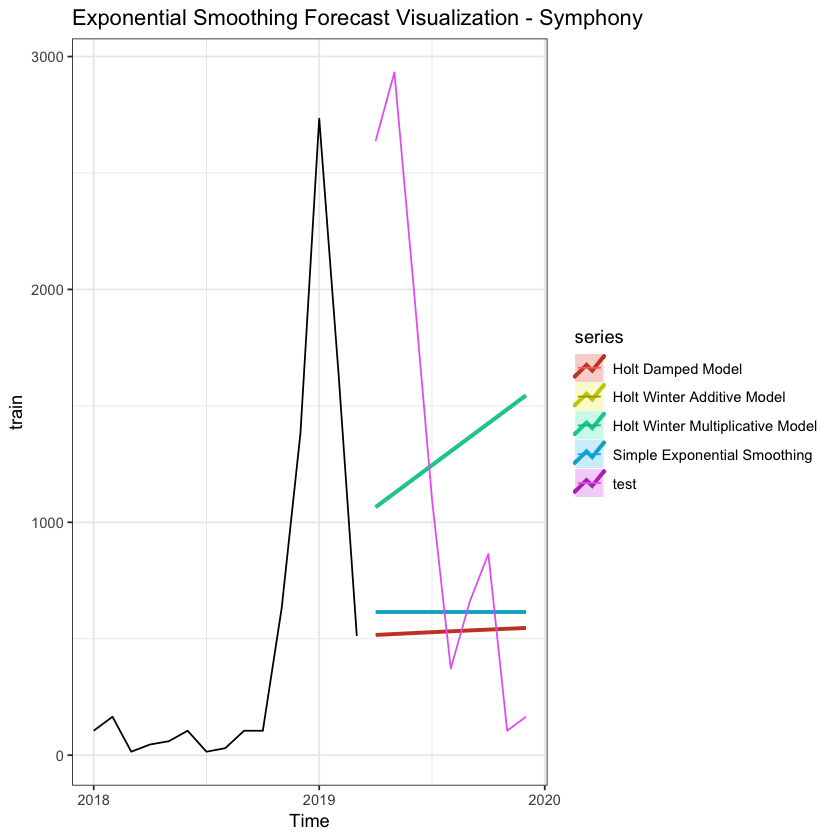

In [20]:
# Visualize forecasts (train & test)
autoplot(train)+
    autolayer(ses_model,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing Forecast Visualization - Symphony")+
    autolayer(test)+theme_bw()

### Step8: Obtain the forecast Value

In [21]:
# obtain predicted value
ses_forecast = forecast(ses_model,h=9)
holt_forecast = forecast(holt_damp_model, h = 9)
hw_additive_forecast = forecast(hw_additive,h=9)
hw_multiplicative_forecast = forecast(hw_multiplicative,h=9)

In [22]:
ses_forecast

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       614.8049 -395.2537 1624.864 -929.9464 2159.556
May 2019       614.8049 -400.2914 1629.901 -937.6510 2167.261
Jun 2019       614.8049 -405.3043 1634.914 -945.3175 2174.927
Jul 2019       614.8049 -410.2926 1639.902 -952.9465 2182.556
Aug 2019       614.8049 -415.2568 1644.867 -960.5385 2190.148
Sep 2019       614.8049 -420.1972 1649.807 -968.0942 2197.704
Oct 2019       614.8049 -425.1141 1654.724 -975.6139 2205.224
Nov 2019       614.8049 -430.0078 1659.618 -983.0983 2212.708
Dec 2019       614.8049 -434.8788 1664.489 -990.5478 2220.158

In [23]:
holt_forecast

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019       516.3324  -405.8796 1438.544  -894.0691 1926.734
May 2019       520.3543  -783.7859 1824.495 -1474.1561 2514.865
Jun 2019       524.2958 -1072.9681 2121.560 -1918.5086 2967.100
Jul 2019       528.1585 -1316.2608 2372.578 -2292.6374 3348.954
Aug 2019       531.9439 -1530.2564 2594.144 -2621.9193 3685.807
Sep 2019       535.6535 -1723.4638 2794.771 -2919.3683 3990.675
Oct 2019       539.2890 -1900.9370 2979.515 -3192.7146 4271.293
Nov 2019       542.8517 -2065.9685 3151.672 -3446.9944 4532.698
Dec 2019       546.3431 -2220.8444 3313.531 -3685.7050 4778.391

In [24]:
hw_additive_forecast

         Point Forecast    Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1065 244.6672 1885.333 -189.59069 2319.591
May 2019           1125 304.6672 1945.333 -129.59069 2379.591
Jun 2019           1185 364.6672 2005.333  -69.59069 2439.591
Jul 2019           1245 424.6672 2065.333   -9.59069 2499.591
Aug 2019           1305 484.6672 2125.333   50.40931 2559.591
Sep 2019           1365 544.6672 2185.333  110.40931 2619.591
Oct 2019           1425 604.6672 2245.333  170.40931 2679.591
Nov 2019           1485 664.6672 2305.333  230.40931 2739.591
Dec 2019           1545 724.6672 2365.333  290.40931 2799.591

In [25]:
hw_multiplicative_forecast

         Point Forecast    Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1065 244.6672 1885.333 -189.59069 2319.591
May 2019           1125 304.6672 1945.333 -129.59069 2379.591
Jun 2019           1185 364.6672 2005.333  -69.59069 2439.591
Jul 2019           1245 424.6672 2065.333   -9.59069 2499.591
Aug 2019           1305 484.6672 2125.333   50.40931 2559.591
Sep 2019           1365 544.6672 2185.333  110.40931 2619.591
Oct 2019           1425 604.6672 2245.333  170.40931 2679.591
Nov 2019           1485 664.6672 2305.333  230.40931 2739.591
Dec 2019           1545 724.6672 2365.333  290.40931 2799.591

### Step 9: Exponential Smoothing Model on the whole dataset

In [26]:
# Simple Exponential Smoothing Model on the whole dataset
library(forecast)
ses_model_all = ses(sales_ts,alpha=0.1, initial="simple")
ses_model_all

         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Jan 2020       833.1178 -365.0619 2031.298  -999.3399 2665.576
Feb 2020       833.1178 -371.0379 2037.273 -1008.4794 2674.715
Mar 2020       833.1178 -376.9844 2043.220 -1017.5737 2683.809
Apr 2020       833.1178 -382.9018 2049.137 -1026.6236 2692.859
May 2020       833.1178 -388.7905 2055.026 -1035.6297 2701.865
Jun 2020       833.1178 -394.6510 2060.887 -1044.5926 2710.828
Jul 2020       833.1178 -400.4837 2066.719 -1053.5129 2719.748
Aug 2020       833.1178 -406.2889 2072.525 -1062.3912 2728.627
Sep 2020       833.1178 -412.0670 2078.303 -1071.2281 2737.464
Oct 2020       833.1178 -417.8185 2084.054 -1080.0242 2746.260

In [27]:
# Holt's methods with damping on the whole dataset
holt_damp_model_all = holt(sales_ts,damped = T)
holt_damp_model_all

         Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       166.1625  -881.3242 1213.649 -1435.830 1768.155
Feb 2020       167.2607 -1314.1047 1648.626 -2098.292 2432.814
Mar 2020       168.2928 -1646.0535 1982.639 -2606.510 2943.096
Apr 2020       169.2629 -1925.8370 2264.363 -3034.916 3373.442
May 2020       170.1746 -2172.3040 2512.653 -3412.337 3752.686
Jun 2020       171.0315 -2395.1191 2737.182 -3753.557 4095.620
Jul 2020       171.8369 -2600.0224 2943.696 -4067.356 4411.030
Aug 2020       172.5939 -2790.7523 3135.940 -4359.453 4704.641
Sep 2020       173.3054 -2969.9050 3316.516 -4633.820 4980.431
Oct 2020       173.9741 -3139.3699 3487.318 -4893.348 5241.296

In [28]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive_all = hw(sales_ts,seasonal = 'additive', damped = T)
hw_additive_all

         Point Forecast      Lo 80    Hi 80      Lo 95     Hi 95
Jan 2020      772.33439  -874.1616 2418.830  -1745.764  3290.433
Feb 2020      -55.60846 -2141.1306 2029.914  -3245.139  3133.922
Mar 2020     -279.07536 -2726.1554 2168.005  -4021.561  3463.411
Apr 2020     -321.62351 -3083.3822 2440.135  -4545.369  3902.122
May 2020     -347.44777 -3391.5737 2696.678  -5003.037  4308.141
Jun 2020     -407.82424 -3710.3005 2894.652  -5458.526  4642.877
Jul 2020     -573.98955 -4116.0548 2968.076  -5991.111  4843.132
Aug 2020     -635.26350 -4401.7355 3131.209  -6395.585  5125.058
Sep 2020     -635.05019 -4613.3142 3343.214  -6719.280  5449.180
Oct 2020     -710.33838 -4889.6958 3469.019  -7102.114  5681.437
Nov 2020     -261.42426 -4632.6513 4109.803  -6946.639  6423.791
Dec 2020      413.32433 -4141.7127 4968.361  -6553.004  7379.652
Jan 2021      820.48839 -3911.2815 5552.258  -6416.129  8057.106
Feb 2021      -12.07937 -4914.1832 4890.024  -7509.200  7485.041
Mar 2021     -239.72697 -

In [29]:
# Holt - winter Multiplicative
hw_multiplicative_all =  hw(sales_ts,seasonal = 'multiplicative', damped = T)
hw_multiplicative_all

         Point Forecast         Lo 80        Hi 80         Lo 95        Hi 95
Jan 2020      -200.6850 -3.623559e+03 3.222189e+03 -5.435519e+03 5.034149e+03
Feb 2020      -900.5313 -7.480483e+04 7.300377e+04 -1.139274e+05 1.121263e+05
Mar 2020      -237.0940 -1.115516e+05 1.110774e+05 -1.704780e+05 1.700038e+05
Apr 2020      -270.9749 -7.962949e+05 7.957530e+05 -1.217685e+06 1.217143e+06
May 2020      -258.7768 -5.014624e+06 5.014106e+06 -7.669068e+06 7.668550e+06
Jun 2020      -309.4480 -4.095146e+07 4.095084e+07 -6.262969e+07 6.262907e+07
Jul 2020      -698.1471 -6.467047e+08 6.467033e+08 -9.890491e+08 9.890477e+08
Aug 2020      -250.6531 -1.655327e+09 1.655326e+09 -2.531604e+09 2.531603e+09
Sep 2020      -206.9924 -9.885283e+09 9.885283e+09 -1.511824e+10 1.511824e+10
Oct 2020       374.4942 -1.308048e+11 1.308048e+11 -2.000487e+11 2.000487e+11
Nov 2020      -926.8432 -2.389690e+12 2.389690e+12 -3.654715e+12 3.654715e+12
Dec 2020     -2826.6237 -5.421195e+13 5.421195e+13 -8.291002e+13

### Step10: Model Forecast Visualization on the whole dataset

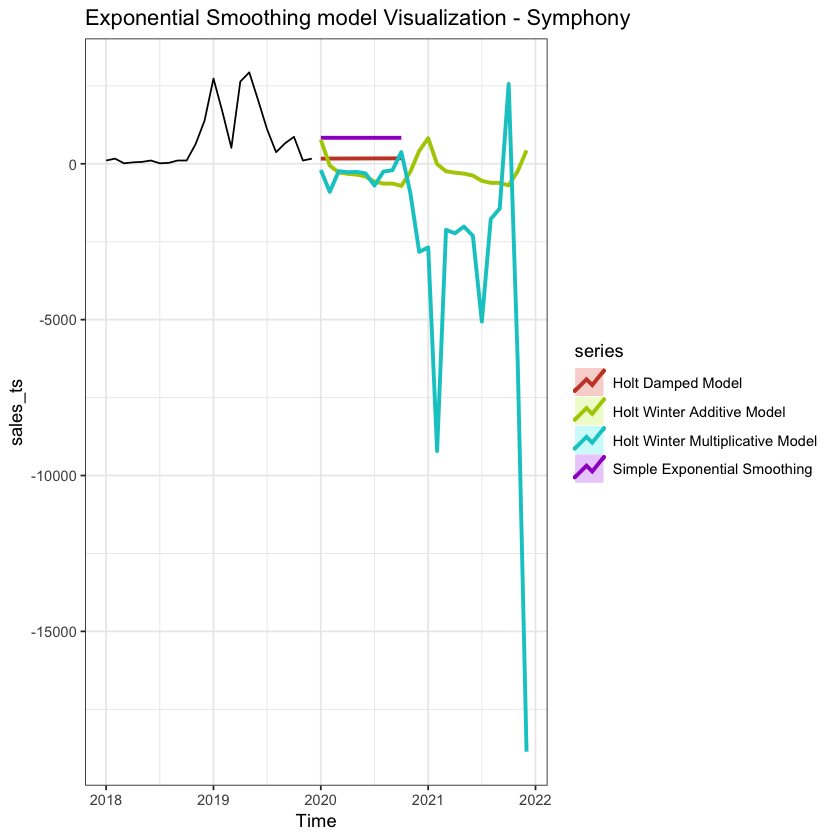

In [30]:
# Visualize forecasts (train & test)
autoplot(sales_ts)+
    autolayer(ses_model_all,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model_all, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive_all, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative_all, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing model Visualization - Symphony")+theme_bw()

### Step10: obtain forecast values on the whole dataset

In [196]:
# obtain predicted value
ses_forecast_all = forecast(ses_model_all)
holt_forecast_all = forecast(holt_damp_model_all)
hw_additive_forecast_all = forecast(hw_additive_all)
hw_multiplicative_forecast_all = forecast(hw_multiplicative_all)

In [197]:
ses_forecast_all

         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Jan 2020       833.1178 -365.0619 2031.298  -999.3399 2665.576
Feb 2020       833.1178 -371.0379 2037.273 -1008.4794 2674.715
Mar 2020       833.1178 -376.9844 2043.220 -1017.5737 2683.809
Apr 2020       833.1178 -382.9018 2049.137 -1026.6236 2692.859
May 2020       833.1178 -388.7905 2055.026 -1035.6297 2701.865
Jun 2020       833.1178 -394.6510 2060.887 -1044.5926 2710.828
Jul 2020       833.1178 -400.4837 2066.719 -1053.5129 2719.748
Aug 2020       833.1178 -406.2889 2072.525 -1062.3912 2728.627
Sep 2020       833.1178 -412.0670 2078.303 -1071.2281 2737.464
Oct 2020       833.1178 -417.8185 2084.054 -1080.0242 2746.260

In [198]:
holt_forecast_all

         Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020       166.1625  -881.3242 1213.649 -1435.830 1768.155
Feb 2020       167.2607 -1314.1047 1648.626 -2098.292 2432.814
Mar 2020       168.2928 -1646.0535 1982.639 -2606.510 2943.096
Apr 2020       169.2629 -1925.8370 2264.363 -3034.916 3373.442
May 2020       170.1746 -2172.3040 2512.653 -3412.337 3752.686
Jun 2020       171.0315 -2395.1191 2737.182 -3753.557 4095.620
Jul 2020       171.8369 -2600.0224 2943.696 -4067.356 4411.030
Aug 2020       172.5939 -2790.7523 3135.940 -4359.453 4704.641
Sep 2020       173.3054 -2969.9050 3316.516 -4633.820 4980.431
Oct 2020       173.9741 -3139.3699 3487.318 -4893.348 5241.296

In [199]:
hw_additive_forecast_all

         Point Forecast      Lo 80    Hi 80      Lo 95     Hi 95
Jan 2020      772.33439  -874.1616 2418.830  -1745.764  3290.433
Feb 2020      -55.60846 -2141.1306 2029.914  -3245.139  3133.922
Mar 2020     -279.07536 -2726.1554 2168.005  -4021.561  3463.411
Apr 2020     -321.62351 -3083.3822 2440.135  -4545.369  3902.122
May 2020     -347.44777 -3391.5737 2696.678  -5003.037  4308.141
Jun 2020     -407.82424 -3710.3005 2894.652  -5458.526  4642.877
Jul 2020     -573.98955 -4116.0548 2968.076  -5991.111  4843.132
Aug 2020     -635.26350 -4401.7355 3131.209  -6395.585  5125.058
Sep 2020     -635.05019 -4613.3142 3343.214  -6719.280  5449.180
Oct 2020     -710.33838 -4889.6958 3469.019  -7102.114  5681.437
Nov 2020     -261.42426 -4632.6513 4109.803  -6946.639  6423.791
Dec 2020      413.32433 -4141.7127 4968.361  -6553.004  7379.652
Jan 2021      820.48839 -3911.2815 5552.258  -6416.129  8057.106
Feb 2021      -12.07937 -4914.1832 4890.024  -7509.200  7485.041
Mar 2021     -239.72697 -

In [200]:
hw_multiplicative_forecast_all

         Point Forecast         Lo 80        Hi 80         Lo 95        Hi 95
Jan 2020      -200.6850 -3.623559e+03 3.222189e+03 -5.435519e+03 5.034149e+03
Feb 2020      -900.5313 -7.480483e+04 7.300377e+04 -1.139274e+05 1.121263e+05
Mar 2020      -237.0940 -1.115516e+05 1.110774e+05 -1.704780e+05 1.700038e+05
Apr 2020      -270.9749 -7.962949e+05 7.957530e+05 -1.217685e+06 1.217143e+06
May 2020      -258.7768 -5.014624e+06 5.014106e+06 -7.669068e+06 7.668550e+06
Jun 2020      -309.4480 -4.095146e+07 4.095084e+07 -6.262969e+07 6.262907e+07
Jul 2020      -698.1471 -6.467047e+08 6.467033e+08 -9.890491e+08 9.890477e+08
Aug 2020      -250.6531 -1.655327e+09 1.655326e+09 -2.531604e+09 2.531603e+09
Sep 2020      -206.9924 -9.885283e+09 9.885283e+09 -1.511824e+10 1.511824e+10
Oct 2020       374.4942 -1.308048e+11 1.308048e+11 -2.000487e+11 2.000487e+11
Nov 2020      -926.8432 -2.389690e+12 2.389690e+12 -3.654715e+12 3.654715e+12
Dec 2020     -2826.6237 -5.421195e+13 5.421195e+13 -8.291002e+13

### Step 11: obtain the accuracy value for the constructed models

In [201]:
# ses model
ses_accuracy = accuracy(ses_forecast,x=sales_ts) # accuracy on train and test sets
ses_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,339.8700,788.1529,397.9668,-74.80680,132.0993,0.2579733,0.6062079,NA
Test set,592.3062,1168.4548,859.5095,-57.61935,125.3601,0.5571583,0.6643006,2.804044


In [202]:
# holt damped model
holt_damped_accuracy = accuracy(holt_forecast, x= sales_ts)
holt_damped_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,23.40442,587.5557,354.6743,-101.57040,160.1691,0.2299099,0.2206880,NA
Test set,675.41976,1220.0328,893.0061,-38.46737,115.1136,0.5788717,0.6650487,2.430239


In [203]:
# hw_additive
hw_additive_accuracy = accuracy(hw_additive_forecast, x = sales_ts)
hw_additive_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-73.33333,640.1091,490.2667,-650.9048,671.0680,0.3178047,0.5582190,NA
Test set,-97.88889,1153.2631,1037.0000,-269.3782,305.5841,0.6722126,0.6736271,8.440268


In [204]:
# hw_multiplicative
hw_multiplicative_accuracy = accuracy(hw_multiplicative_forecast, x = sales_ts)
hw_multiplicative_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-73.33333,640.1091,490.2667,-650.9048,671.0680,0.3178047,0.5582190,NA
Test set,-97.88889,1153.2631,1037.0000,-269.3782,305.5841,0.6722126,0.6736271,8.440268
